# Pre-Activation Residual (ResNet v2) — Temelden İleri Seviyeye Notlar

> Bu defter, *residual* fikrinin temelinden başlayıp **pre-activation residual block (ResNet v2)** mantığına kadar adım adım gider.  
> Amaç: “neden böyle tasarlanmış?” sorusunu net cevaplayacak şekilde, teori + PyTorch kodu ile.


## İçindekiler
1. Residual fikri: neden “skip connection”?
2. Basic Residual Block (ResNet v1) — post-activation mantığı
3. Boyut uyuşmazlığı: projection skip (1×1 conv) ne zaman gerekir?
4. Bottleneck blok ve neden var?
5. Sorun: post-activation blokta neden bazı şeyler tıkanır?
6. **Pre-Activation Residual (ResNet v2):** temel fikir ve matematik
7. v1 vs v2: farklar (pratik + gradient akışı)
8. PyTorch implementasyonları (Basic v1, Bottleneck v1, PreAct Basic, PreAct Bottleneck)
9. Mini deney: aynı parametre yakınında hızlı karşılaştırma (kısa eğitim)
10. Debug checklist + küçük alıştırmalar

## 1) Residual fikri: neden “skip connection”?

Derin ağlar büyüdükçe iki klasik problem görürsün:

- **Vanishing / exploding gradient:** geriye doğru sinyal ya kaybolur ya patlar.
- **Degradation problem:** teoride daha derin ağ daha iyi olmalı; pratikte *daha derin* ağ bazen daha kötüleşir (train hatası bile artabilir).

Residual yaklaşım şunu der:

> “Ağ, doğrudan `H(x)` öğrenmek yerine **artık/kalıntı** olan `F(x) = H(x) - x`’i öğrensin.”

Böylece:
\[
y = x + F(x)
\]

Burada skip path `x`’i direkt geçirir. Main path `F(x)` üretir.

**İşin kritik noktası:** gradient geri yayılımda `x` yolundan daha rahat akar. Bu “identity highway” gibi çalışır.

## 2) Basic Residual Block (ResNet v1) — post-activation

ResNet v1’de tipik basic blok şu sırada olur:

**Main path:**  
`Conv → BN → ReLU → Conv → BN`

**Toplama:**  
`y = x + F(x)`

**Son aktivasyon (post-activation):**  
`ReLU(y)`

Yani blok “biterken” ReLU var.  
Bu yüzden v1’e bazen **post-activation** denir (aktivasyon, residual toplamadan sonra geliyor).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("torch:", torch.__version__)

torch: 2.9.1+cpu


## 3) Boyut uyuşmazlığı: projection skip ne zaman gerekir?

Toplama yapacağın için `x` ile `F(x)` aynı shape olmalı.

Durum 1: **stride=1 ve kanal aynı** → identity skip
- skip: `x`

Durum 2: **stride=2 (downsample) veya kanal değişti** → projection skip
- skip: genelde `1×1 conv (stride=...) + BN`

Kısa kural:
- main path çıkışı ne yaptıysa (spatial küçülttü / kanal değiştirdi), skip path de aynı shape’e getirir.

## 4) Bottleneck blok (ResNet-50/101/152) ve neden var?

Deep ResNet’lerde (50+ katman) “basic block” çok pahalı olur.

Bottleneck fikri:
- önce kanalı düşür (1×1)
- sonra asıl iş (3×3)
- sonra kanalı geri çıkar (1×1)

Sıra (v1 bottleneck):
`1×1 conv → BN → ReLU → 3×3 conv → BN → ReLU → 1×1 conv → BN`  
Toplama sonra `ReLU`.

Neden işe yarar?
- hesap daha ucuz (özellikle 3×3’te kanal düşük tutulur)
- daha derin ağ mümkün olur

## 5) Post-activation (v1) blokta “tıkanma” nereden gelir?

v1 blokta residual toplamadan sonra ReLU var:

\[
y = \text{ReLU}(x + F(x))
\]

Bu şu anlama geliyor:
- Skip yolundan gelen bilgi bile ReLU ile kesilebilir (`x + F(x)` negatifse sıfırlanır).
- Çok derin ağlarda bu küçük bir “gürültü” gibi değil; *katman katman* birikir.

Buradan çıkan fikir:
> “Skip yolunu olabildiğince **tam identity** bırak.  
> Aktivasyon / normalizasyonu toplamadan **önce** yap.”

Bu bizi v2’ye götürüyor.

## 6) Pre-Activation Residual (ResNet v2): temel fikir

v2’de blok sırası değişir:

**BN → ReLU → Conv → BN → ReLU → Conv**  
Toplama: `y = x + F(x)`  
**ve blok sonunda ReLU yok**.

Yani:
- Aktivasyonlar “main path” içine taşınır.
- Skip yolu daha “temiz” kalır.

Matematiksel olarak (basit düşün):
\[
y = x + F(\text{BN+ReLU}(x))
\]

Buradaki kritik nokta:
- Gradient, `x` üzerinden daha az bariyerle akar (çünkü “post-ReLU” yok).
- Çok derin ağlarda optimizasyon daha stabil hale gelir.

### 6.1) v2’nin pratik sonucu

- Derinlik arttıkça (ör. 1000+ katman gibi) eğitim daha mümkün.
- Aynı derinlikte, bazen daha hızlı konverjans / daha iyi genelleme.

Not: Bu “mutlak her zaman v2 daha iyi” demek değil.  
Ama v2’nin tasarım gerekçesi net: skip yolunu **mümkün olduğunca identity** tutmak.

## 7) v1 vs v2: farkları net tablo

**v1 (post-activation)**  
- Toplamadan sonra `ReLU`
- Blok çıkışı nonlinearity içerir
- Skip yolu ReLU tarafından kesilebilir

**v2 (pre-activation)**  
- `BN+ReLU` toplamadan önce
- Blok sonunda aktivasyon yok
- Skip yolu daha saf identity

Ek pratik fark:
- v2’de “downsample/projection” gerektiğinde, çoğu implementasyonda skip projeksiyonu yine yapılır ama main path pre-activation akışına uyarlanır.

## 8) PyTorch implementasyonları

Aşağıda 4 blok yazacağız:
1. `BasicBlockV1`
2. `BottleneckV1`
3. `PreActBasicBlock` (v2)
4. `PreActBottleneck` (v2)

Amaç: blokların “sıra farkını” çıplak görmek.

In [3]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=None, groups=1):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, groups=groups, bias=False)
        self.bn   = nn.BatchNorm2d(out_ch)
        self.act  = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class BasicBlockV1(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)  # post-activation
        return out

class BottleneckV1(nn.Module):
    expansion = 4
    def __init__(self, in_ch, mid_ch, stride=1):
        super().__init__()
        out_ch = mid_ch * self.expansion

        self.conv1 = nn.Conv2d(in_ch, mid_ch, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, mid_ch, 3, stride=stride, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid_ch)
        self.conv3 = nn.Conv2d(mid_ch, out_ch, 1, bias=False)
        self.bn3   = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_ch),
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.relu(out)  # post-activation
        return out

In [4]:
class PreActBasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        self.bn1  = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=stride, padding=1, bias=False)

        self.bn2  = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1, bias=False)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            # v2'de skip projection genelde conv1x1 (BN çoğu implementasyonda opsiyonel)
            self.downsample = nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False)

    def forward(self, x):
        out = self.relu(self.bn1(x))

        identity = x
        if self.downsample is not None:
            identity = self.downsample(out)  # dikkat: bazı v2'lerde projeksiyon pre-activated x üzerinden

        out = self.conv1(out)
        out = self.conv2(self.relu(self.bn2(out)))

        out = out + identity
        # block sonunda ReLU yok (pre-activation)
        return out

class PreActBottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_ch, mid_ch, stride=1):
        super().__init__()
        out_ch = mid_ch * self.expansion

        self.bn1  = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_ch, mid_ch, 1, bias=False)

        self.bn2  = nn.BatchNorm2d(mid_ch)
        self.conv2 = nn.Conv2d(mid_ch, mid_ch, 3, stride=stride, padding=1, bias=False)

        self.bn3  = nn.BatchNorm2d(mid_ch)
        self.conv3 = nn.Conv2d(mid_ch, out_ch, 1, bias=False)

        self.downsample = None
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.Conv2d(in_ch, out_ch, 1, stride=stride, bias=False)

    def forward(self, x):
        out = self.relu(self.bn1(x))

        identity = x
        if self.downsample is not None:
            identity = self.downsample(out)

        out = self.conv1(out)
        out = self.conv2(self.relu(self.bn2(out)))
        out = self.conv3(self.relu(self.bn3(out)))

        out = out + identity
        return out

### 8.1) Hızlı şekil testi

Aşağıda aynı input ile blokların output shape'lerini kontrol edelim.  
(Downsample olan durumda skip projeksiyonun doğru çalıştığını görmek için.)

In [5]:
x = torch.randn(2, 64, 56, 56)

b1 = BasicBlockV1(64, 64, stride=1)
b2 = BasicBlockV1(64, 128, stride=2)

p1 = PreActBasicBlock(64, 64, stride=1)
p2 = PreActBasicBlock(64, 128, stride=2)

with torch.no_grad():
    print("Basic v1 s1:", b1(x).shape)
    print("Basic v1 s2:", b2(x).shape)
    print("PreAct v2 s1:", p1(x).shape)
    print("PreAct v2 s2:", p2(x).shape)

Basic v1 s1: torch.Size([2, 64, 56, 56])
Basic v1 s2: torch.Size([2, 128, 28, 28])
PreAct v2 s1: torch.Size([2, 64, 56, 56])
PreAct v2 s2: torch.Size([2, 128, 28, 28])


## 9) Mini deney: v1 vs v2 hızlı karşılaştırma

Bu bölüm “benchmark” iddiası değil.  
Sadece aynı tarz küçük bir CNN/ResNet iskeletinde:
- loss akışı nasıl gidiyor?
- gradient normları kabaca stabil mi?

GPU varsa hızlanır, yoksa CPU’da da çalışır ama yavaş olabilir.

Aşağıdaki kodda:
- basit bir “tiny resnet” kuruyoruz
- random data ile birkaç iterasyon eğitiyoruz
- loss düşüşüne ve gradient normuna bakıyoruz

Not: Gerçek kıyas için CIFAR10 gibi dataset gerekir; ama şimdilik amaç mekanik farkı gözlemlemek.

In [ ]:
class TinyResNet(nn.Module):
    def __init__(self, block, layers=(2,2,2), num_classes=10, base=32):
        super().__init__()
        self.in_ch = base
        self.stem = nn.Sequential(
            nn.Conv2d(3, base, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(inplace=True),
        )

        self.stage1 = self._make_stage(block, base,  layers[0], stride=1)
        self.stage2 = self._make_stage(block, base*2, layers[1], stride=2)
        self.stage3 = self._make_stage(block, base*4, layers[2], stride=2)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.in_ch, num_classes)
        )

    def _make_stage(self, block, out_ch, n, stride):
        layers = []
        layers.append(block(self.in_ch, out_ch, stride=stride))
        self.in_ch = out_ch * getattr(block, "expansion", 1)
        for _ in range(n-1):
            layers.append(block(self.in_ch, out_ch, stride=1))
            self.in_ch = out_ch * getattr(block, "expansion", 1)
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.head(x)
        return x

def train_steps(model, steps=30, batch=32, device="cpu"):
    model.to(device)
    model.train()
    opt = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=1e-4)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    grad_norms = []

    for t in range(steps):
        x = torch.randn(batch, 3, 32, 32, device=device)
        y = torch.randint(0, 10, (batch,), device=device)

        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()

        # global grad norm (rough)
        total_norm = 0.0
        for p in model.parameters():
            if p.grad is None:
                continue
            param_norm = p.grad.data.norm(2).item()
            total_norm += param_norm ** 2
        total_norm = total_norm ** 0.5

        opt.step()

        losses.append(loss.item())
        grad_norms.append(total_norm)

    return losses, grad_norms

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

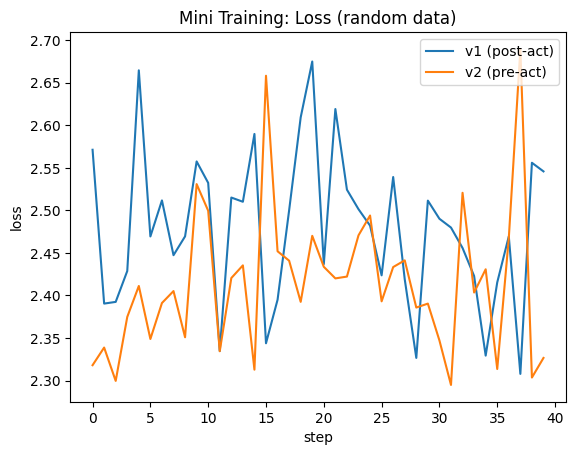

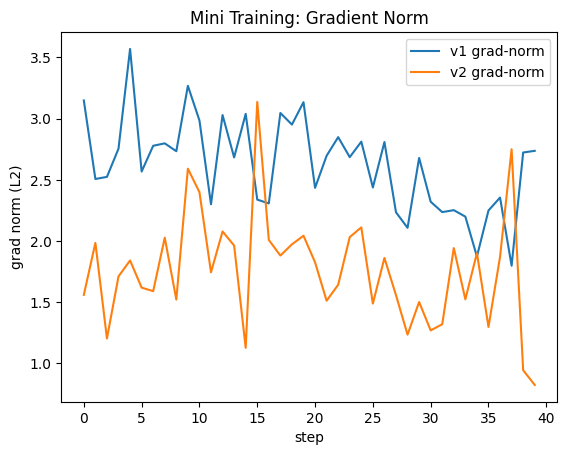

In [ ]:
import matplotlib.pyplot as plt

m_v1 = TinyResNet(BasicBlockV1, layers=(2,2,2), base=32)
m_v2 = TinyResNet(PreActBasicBlock, layers=(2,2,2), base=32)

loss_v1, gn_v1 = train_steps(m_v1, steps=40, batch=64, device=device)
loss_v2, gn_v2 = train_steps(m_v2, steps=40, batch=64, device=device)

plt.figure()
plt.plot(loss_v1, label="v1 (post-act)")
plt.plot(loss_v2, label="v2 (pre-act)")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.title("Mini Training: Loss (random data)")
plt.show()

plt.figure()
plt.plot(gn_v1, label="v1 grad-norm")
plt.plot(gn_v2, label="v2 grad-norm")
plt.xlabel("step")
plt.ylabel("grad norm (L2)")
plt.legend()
plt.title("Mini Training: Gradient Norm")
plt.show()

## 10) Debug checklist (residual blok yazarken en çok patlayan yerler)

1. **Shape uyuşmazlığı:** `x` ile `F(x)` aynı değil → downsample/projection unutulmuş.
2. **Stride yanlış yerde:** stage başında stride uygulanmalı, her blokta değil.
3. **BN channel yanlış:** PreAct’te ilk BN input channel’a göre açılır.
4. **Downsample hangi tensordan?**  
   - v1: genelde `identity = downsample(x)`  
   - v2: çoğu pratik kodda `downsample(preact(x))` veya `downsample(x)` varyasyonları var.  
     (Bu küçük farklar implementasyona göre değişir.)
5. **ReLU inplace:** bazen gradient debug yaparken sorun çıkarabilir; gerekirse `inplace=False`.

## 11) Kapanış: özet (tek paragraf)

Residual bloklar “derinliği optimize edilebilir” hale getirir; v1’de toplamadan sonra ReLU olduğu için skip yolu da kesilebilir. v2 (pre-activation) bu bariyeri azaltıp BN+ReLU’yu toplamadan önce alır ve blok sonunda aktivasyonu kaldırır. Sonuç: skip yolu daha identity kalır, derin ağlarda eğitim daha stabil olur.

**Post-activation’da aktivasyon toplamadan sonra,**

**Pre-activation’da aktivasyon toplamadan önce gelir.**

| Özellik        | Post-Activation (v1) | Pre-Activation (v2) |
| -------------- | -------------------- | ------------------- |
| ReLU yeri      | Toplamadan sonra     | Toplamadan önce     |
| Skip yolu      | ReLU’dan geçer       | Direkt geçer        |
| Gradient akışı | Kısmen kesilebilir   | Çok temiz           |
| Derin ağlar    | Daha zor             | Daha stabil         |
